# First Activity (IC2)

**Professor: Ricardo Prudêncio**

Task:

(PT-BR) Escolha uma base de dados do seu interesse (ver por exemplo repositórios como UCI, OpenML, Kaggle). Gera uma árvore compacta (por exemplo, com até dois níveis no máximo) para o conjunto de dados do seu interesse. Treine também os outros modelos, como Random Forest, Regressão Logística, Naive Bayes e kNN. Calcule a curva ROC dos modelos para comparar qual modelo foi mais bem sucedido para essa base de exemplos.

(EN) Choose a dataset of your interest (for example, see repositories like UCI, OpenML, Kaggle). Generate a compact tree (e.g., with up to two levels at most) for the dataset of your interest. Also, train other models, such as Random Forest, Logistic Regression, Naive Bayes, and kNN. Calculate the ROC curve for the models to compare which model was more successful for this dataset.

## Import necessary libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import optuna


## Load the dataset

In [2]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

The Housing Prices dataset, often referred to as the Ames Housing dataset, is a popular dataset used in machine learning and data science for regression tasks. It includes detailed information on 1,460 houses sold in Ames, Iowa, between 2006 and 2010. The dataset features 79 explanatory variables that describe various aspects of the houses, such as the number of bedrooms, square footage, neighborhood, and year built. The target variable, SalePrice, represents the price each house sold for, making this dataset an excellent resource for modeling and predicting real estate prices based on a diverse set of factors. The dataset is commonly used to practice feature engineering, data preprocessing, and model evaluation in predictive analytics.

## Exploratory Data Analysis (EDA)
-------------------------------
Check for missing values.

In [3]:
print(train_data.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


### Distribution
Visualize the distribution of the target variable 'SalePrice'.


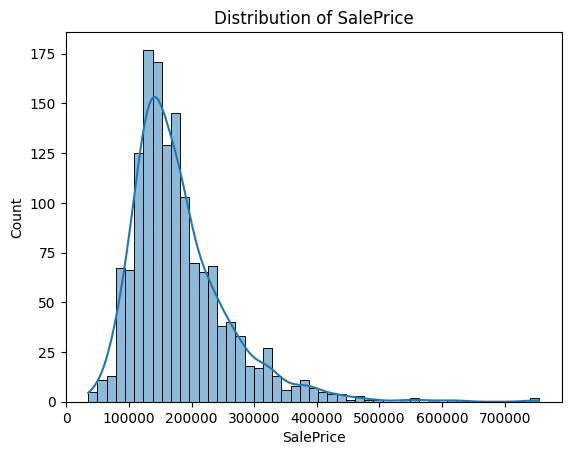

In [4]:
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

### Correlation heatmap
We select only numerical features for correlation matrix.

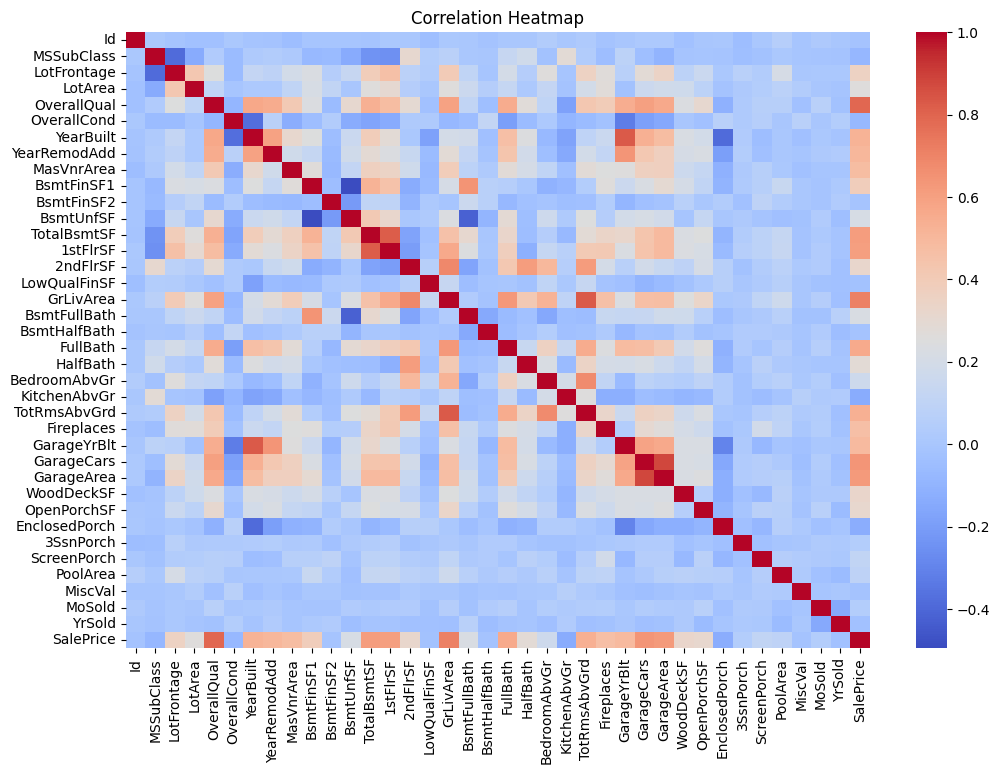

In [5]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numerical_features].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Data Preprocessing
---
Handle missing values, categorical features, and feature scaling.

In [6]:
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

In [7]:
numeric_features = numeric_features.drop(['Id','SalePrice'])

Ensure these columns are correct.

In [8]:
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numeric Features: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Categorical Features: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

Define preprocessing for numerical columns (impute missing values).

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

Define preprocessing for categorical columns (impute missing values, then apply one-hot encoding).

In [10]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Combine preprocessing steps.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Define the target variable and features.

In [12]:
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']

#### Convert SalePrice to a binary target

Since one of the requirements of this activity is to plot a ROC AUC curve, we must have a binary outcome. In order to do that, we can transform the *SalePrice* attribute (which is numerical) to be either higher or lower that a certain threshold. We can set the threshold as the median of this attribute. 

Let's say houses above the median price are classified as 1, below or equal to median as 0.

In [13]:
median_price = train_data['SalePrice'].median()
y_binary = (y > median_price).astype(int)

In [14]:
X = preprocessor.fit_transform(X).toarray()

Define cross-validation strategy.

We made sure that the data was well distributed regarding the target class (SalePrice). Nevertheless, for easy replicability, we stratify de data.

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Modeling Robust Model (Using Ensemble)

#### Handle Hyperparemeter Optimization
Initialize dictionaries to store the studies.

In [16]:
best_studies = {}

In [17]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    score = cross_val_score(rf_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=rf_model)
    
    return score

In [18]:
def objective_lr(trial):
    C = trial.suggest_loguniform("C", 1e-5, 1e2)
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "sag", "saga"])
    lr_model = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, solver=solver, max_iter=500, random_state=42)
    )
    
    score = cross_val_score(lr_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=lr_model)
    
    return score

In [19]:
def objective_nb(trial):
    var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)
    nb_model = GaussianNB(var_smoothing=var_smoothing)
    
    score = cross_val_score(nb_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=nb_model)
    
    return score

In [20]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 20)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    knn_model = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    )
    
    score = cross_val_score(knn_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=knn_model)
    
    return score

In [21]:
def objective_dt(trial):
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    dt_model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    
    score = cross_val_score(dt_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=dt_model)
    
    return score

Define a single callback function to store the best model in the study's user attributes.

In [22]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Create Optuna studies and optimize each model with the single callback.

In [23]:
for model_name, objective in [("Random Forest", objective_rf),
                              ("Logistic Regression", objective_lr),
                              ("Naive Bayes", objective_nb),
                              ("KNN", objective_knn),
                              ("Decision Tree", objective_dt)]:
    
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction="maximize")
    
    study.optimize(objective, n_trials=50, callbacks=[callback], show_progress_bar=True)
    print(150*'-')
    
    best_studies[model_name] = study

# After optimization, retrieve the best models from each study
best_models = {model_name: study.user_attrs["best_model"] for model_name, study in best_studies.items()}


[I 2024-08-21 18:15:09,820] A new study created in memory with name: no-name-06042408-0cbf-4f9c-a468-dc8d10261313


Optimizing Random Forest...


Best trial: 0. Best value: 0.973616:   2%|▏         | 1/50 [00:01<01:16,  1.56s/it]

[I 2024-08-21 18:15:11,383] Trial 0 finished with value: 0.9736156303456799 and parameters: {'n_estimators': 234, 'max_depth': 4}. Best is trial 0 with value: 0.9736156303456799.


Best trial: 1. Best value: 0.978011:   4%|▍         | 2/50 [00:02<00:57,  1.21s/it]

[I 2024-08-21 18:15:12,337] Trial 1 finished with value: 0.9780114780979462 and parameters: {'n_estimators': 63, 'max_depth': 16}. Best is trial 1 with value: 0.9780114780979462.


Best trial: 2. Best value: 0.979095:   6%|▌         | 3/50 [00:03<00:53,  1.13s/it]

[I 2024-08-21 18:15:13,384] Trial 2 finished with value: 0.9790951865051156 and parameters: {'n_estimators': 102, 'max_depth': 14}. Best is trial 2 with value: 0.9790951865051156.


Best trial: 2. Best value: 0.979095:   8%|▊         | 4/50 [00:04<00:54,  1.18s/it]

[I 2024-08-21 18:15:14,630] Trial 3 finished with value: 0.9738877330265746 and parameters: {'n_estimators': 277, 'max_depth': 4}. Best is trial 2 with value: 0.9790951865051156.


Best trial: 4. Best value: 0.980512:  10%|█         | 5/50 [00:05<00:42,  1.05it/s]

[I 2024-08-21 18:15:15,188] Trial 4 finished with value: 0.9805119839848764 and parameters: {'n_estimators': 257, 'max_depth': 13}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  12%|█▏        | 6/50 [00:05<00:32,  1.36it/s]

[I 2024-08-21 18:15:15,494] Trial 5 finished with value: 0.9795080186324858 and parameters: {'n_estimators': 101, 'max_depth': 11}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  14%|█▍        | 7/50 [00:05<00:24,  1.78it/s]

[I 2024-08-21 18:15:15,704] Trial 6 finished with value: 0.9780724655901146 and parameters: {'n_estimators': 54, 'max_depth': 20}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  16%|█▌        | 8/50 [00:06<00:20,  2.09it/s]

[I 2024-08-21 18:15:16,000] Trial 7 finished with value: 0.9787574096423434 and parameters: {'n_estimators': 97, 'max_depth': 12}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  18%|█▊        | 9/50 [00:06<00:18,  2.17it/s]

[I 2024-08-21 18:15:16,421] Trial 8 finished with value: 0.9797426068867443 and parameters: {'n_estimators': 178, 'max_depth': 19}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  20%|██        | 10/50 [00:06<00:16,  2.35it/s]

[I 2024-08-21 18:15:16,766] Trial 9 finished with value: 0.980324334158379 and parameters: {'n_estimators': 140, 'max_depth': 13}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  22%|██▏       | 11/50 [00:07<00:17,  2.17it/s]

[I 2024-08-21 18:15:17,310] Trial 10 finished with value: 0.9804087702856037 and parameters: {'n_estimators': 296, 'max_depth': 8}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  24%|██▍       | 12/50 [00:08<00:18,  2.05it/s]

[I 2024-08-21 18:15:17,861] Trial 11 finished with value: 0.9803618545275636 and parameters: {'n_estimators': 292, 'max_depth': 8}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  26%|██▌       | 13/50 [00:08<00:20,  1.78it/s]

[I 2024-08-21 18:15:18,590] Trial 12 finished with value: 0.9801648220776847 and parameters: {'n_estimators': 235, 'max_depth': 8}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  28%|██▊       | 14/50 [00:09<00:22,  1.57it/s]

[I 2024-08-21 18:15:19,396] Trial 13 finished with value: 0.9801929686272631 and parameters: {'n_estimators': 243, 'max_depth': 8}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 4. Best value: 0.980512:  30%|███       | 15/50 [00:10<00:22,  1.53it/s]

[I 2024-08-21 18:15:20,088] Trial 14 finished with value: 0.9795549493569438 and parameters: {'n_estimators': 201, 'max_depth': 10}. Best is trial 4 with value: 0.9805119839848764.


Best trial: 15. Best value: 0.980756:  32%|███▏      | 16/50 [00:11<00:25,  1.36it/s]

[I 2024-08-21 18:15:21,014] Trial 15 finished with value: 0.9807559352741169 and parameters: {'n_estimators': 300, 'max_depth': 16}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  34%|███▍      | 17/50 [00:12<00:25,  1.30it/s]

[I 2024-08-21 18:15:21,864] Trial 16 finished with value: 0.9804040769930635 and parameters: {'n_estimators': 263, 'max_depth': 17}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  36%|███▌      | 18/50 [00:12<00:22,  1.40it/s]

[I 2024-08-21 18:15:22,446] Trial 17 finished with value: 0.9801789028356828 and parameters: {'n_estimators': 209, 'max_depth': 16}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  38%|███▊      | 19/50 [00:13<00:22,  1.35it/s]

[I 2024-08-21 18:15:23,254] Trial 18 finished with value: 0.9803102448167003 and parameters: {'n_estimators': 257, 'max_depth': 14}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  40%|████      | 20/50 [00:14<00:21,  1.38it/s]

[I 2024-08-21 18:15:23,943] Trial 19 finished with value: 0.9799208778314646 and parameters: {'n_estimators': 204, 'max_depth': 18}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  42%|████▏     | 21/50 [00:14<00:19,  1.48it/s]

[I 2024-08-21 18:15:24,498] Trial 20 finished with value: 0.9795549407732629 and parameters: {'n_estimators': 152, 'max_depth': 15}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  44%|████▍     | 22/50 [00:15<00:20,  1.36it/s]

[I 2024-08-21 18:15:25,372] Trial 21 finished with value: 0.9787574131638538 and parameters: {'n_estimators': 300, 'max_depth': 6}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  46%|████▌     | 23/50 [00:16<00:20,  1.30it/s]

[I 2024-08-21 18:15:26,194] Trial 22 finished with value: 0.9802211222198615 and parameters: {'n_estimators': 276, 'max_depth': 10}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  48%|████▊     | 24/50 [00:17<00:20,  1.29it/s]

[I 2024-08-21 18:15:27,002] Trial 23 finished with value: 0.9787011169833757 and parameters: {'n_estimators': 299, 'max_depth': 6}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  50%|█████     | 25/50 [00:18<00:19,  1.25it/s]

[I 2024-08-21 18:15:27,866] Trial 24 finished with value: 0.9803712397920776 and parameters: {'n_estimators': 271, 'max_depth': 12}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  52%|█████▏    | 26/50 [00:18<00:18,  1.27it/s]

[I 2024-08-21 18:15:28,621] Trial 25 finished with value: 0.9800428470933479 and parameters: {'n_estimators': 249, 'max_depth': 10}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  54%|█████▍    | 27/50 [00:19<00:17,  1.34it/s]

[I 2024-08-21 18:15:29,269] Trial 26 finished with value: 0.9801225936696367 and parameters: {'n_estimators': 222, 'max_depth': 14}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  56%|█████▌    | 28/50 [00:20<00:16,  1.31it/s]

[I 2024-08-21 18:15:30,068] Trial 27 finished with value: 0.978776175769484 and parameters: {'n_estimators': 282, 'max_depth': 6}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  58%|█████▊    | 29/50 [00:21<00:16,  1.26it/s]

[I 2024-08-21 18:15:30,946] Trial 28 finished with value: 0.9804040767729691 and parameters: {'n_estimators': 260, 'max_depth': 17}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 15. Best value: 0.980756:  60%|██████    | 30/50 [00:21<00:14,  1.39it/s]

[I 2024-08-21 18:15:31,480] Trial 29 finished with value: 0.9681642161138402 and parameters: {'n_estimators': 220, 'max_depth': 3}. Best is trial 15 with value: 0.9807559352741169.


Best trial: 30. Best value: 0.980869:  62%|██████▏   | 31/50 [00:22<00:14,  1.30it/s]

[I 2024-08-21 18:15:32,372] Trial 30 finished with value: 0.9808685311565822 and parameters: {'n_estimators': 287, 'max_depth': 13}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  64%|██████▍   | 32/50 [00:23<00:14,  1.22it/s]

[I 2024-08-21 18:15:33,301] Trial 31 finished with value: 0.9807277882843497 and parameters: {'n_estimators': 283, 'max_depth': 13}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  66%|██████▌   | 33/50 [00:24<00:14,  1.13it/s]

[I 2024-08-21 18:15:34,334] Trial 32 finished with value: 0.9807747031620122 and parameters: {'n_estimators': 285, 'max_depth': 13}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  68%|██████▊   | 34/50 [00:25<00:14,  1.12it/s]

[I 2024-08-21 18:15:35,249] Trial 33 finished with value: 0.9806433360902354 and parameters: {'n_estimators': 285, 'max_depth': 15}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  70%|███████   | 35/50 [00:26<00:13,  1.14it/s]

[I 2024-08-21 18:15:36,102] Trial 34 finished with value: 0.9806574082645527 and parameters: {'n_estimators': 278, 'max_depth': 15}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  72%|███████▏  | 36/50 [00:26<00:11,  1.22it/s]

[I 2024-08-21 18:15:36,770] Trial 35 finished with value: 0.9803618686136041 and parameters: {'n_estimators': 241, 'max_depth': 13}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  74%|███████▍  | 37/50 [00:27<00:10,  1.24it/s]

[I 2024-08-21 18:15:37,564] Trial 36 finished with value: 0.9808028505919681 and parameters: {'n_estimators': 273, 'max_depth': 11}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  76%|███████▌  | 38/50 [00:28<00:09,  1.23it/s]

[I 2024-08-21 18:15:38,382] Trial 37 finished with value: 0.9807653200984421 and parameters: {'n_estimators': 269, 'max_depth': 11}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  78%|███████▊  | 39/50 [00:29<00:09,  1.20it/s]

[I 2024-08-21 18:15:39,258] Trial 38 finished with value: 0.9807277909254823 and parameters: {'n_estimators': 267, 'max_depth': 11}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  80%|████████  | 40/50 [00:29<00:07,  1.38it/s]

[I 2024-08-21 18:15:39,731] Trial 39 finished with value: 0.9799208879558062 and parameters: {'n_estimators': 182, 'max_depth': 9}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  82%|████████▏ | 41/50 [00:30<00:06,  1.40it/s]

[I 2024-08-21 18:15:40,428] Trial 40 finished with value: 0.9804650695474028 and parameters: {'n_estimators': 224, 'max_depth': 11}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  84%|████████▍ | 42/50 [00:31<00:05,  1.40it/s]

[I 2024-08-21 18:15:41,141] Trial 41 finished with value: 0.9802023494898894 and parameters: {'n_estimators': 251, 'max_depth': 12}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  86%|████████▌ | 43/50 [00:32<00:05,  1.26it/s]

[I 2024-08-21 18:15:42,115] Trial 42 finished with value: 0.9807746980998416 and parameters: {'n_estimators': 289, 'max_depth': 16}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  88%|████████▊ | 44/50 [00:33<00:04,  1.24it/s]

[I 2024-08-21 18:15:42,944] Trial 43 finished with value: 0.9804744416062541 and parameters: {'n_estimators': 267, 'max_depth': 14}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  90%|█████████ | 45/50 [00:33<00:04,  1.21it/s]

[I 2024-08-21 18:15:43,816] Trial 44 finished with value: 0.9803524749855035 and parameters: {'n_estimators': 288, 'max_depth': 12}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  92%|█████████▏| 46/50 [00:34<00:02,  1.48it/s]

[I 2024-08-21 18:15:44,149] Trial 45 finished with value: 0.9797426071068387 and parameters: {'n_estimators': 81, 'max_depth': 9}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  94%|█████████▍| 47/50 [00:34<00:01,  1.68it/s]

[I 2024-08-21 18:15:44,555] Trial 46 finished with value: 0.9804932191783022 and parameters: {'n_estimators': 132, 'max_depth': 13}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  96%|█████████▌| 48/50 [00:35<00:01,  1.47it/s]

[I 2024-08-21 18:15:45,425] Trial 47 finished with value: 0.9808403815256828 and parameters: {'n_estimators': 274, 'max_depth': 11}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869:  98%|█████████▊| 49/50 [00:36<00:00,  1.40it/s]

[I 2024-08-21 18:15:46,215] Trial 48 finished with value: 0.980652718053334 and parameters: {'n_estimators': 289, 'max_depth': 18}. Best is trial 30 with value: 0.9808685311565822.


Best trial: 30. Best value: 0.980869: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]
[I 2024-08-21 18:15:47,008] A new study created in memory with name: no-name-18945b34-30dd-41de-a292-dc83830c0f39


[I 2024-08-21 18:15:47,001] Trial 49 finished with value: 0.9800147040652796 and parameters: {'n_estimators': 233, 'max_depth': 9}. Best is trial 30 with value: 0.9808685311565822.
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimizing Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 0. Best value: 0.9699:   2%|▏         | 1/50 [00:00<00:07,  6.26it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:47,167] Trial 0 finished with value: 0.9699000357741404 and parameters: {'C': 0.2702348128701602, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:   4%|▍         | 2/50 [00:00<00:08,  5.79it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:47,349] Trial 1 finished with value: 0.9685394801115456 and parameters: {'C': 0.0004540204122342474, 'solver': 'sag'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:   6%|▌         | 3/50 [00:02<00:41,  1.13it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:49,082] Trial 2 finished with value: 0.9679108817610297 and parameters: {'C': 0.6612713037813234, 'solver': 'sag'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:   8%|▊         | 4/50 [00:03<00:52,  1.14s/it]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:50,596] Trial 3 finished with value: 0.9693839857657041 and parameters: {'C': 0.3269236979475882, 'solver': 'sag'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:  10%|█         | 5/50 [00:05<01:04,  1.44s/it]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:52,582] Trial 4 finished with value: 0.9678264372702188 and parameters: {'C': 46.22338764564265, 'solver': 'saga'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:  12%|█▏        | 6/50 [00:06<00:49,  1.13s/it]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:53,122] Trial 5 finished with value: 0.9576553874019826 and parameters: {'C': 44.751468679111845, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 0. Best value: 0.9699:  14%|█▍        | 7/50 [00:07<00:56,  1.32s/it]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:54,829] Trial 6 finished with value: 0.9673385214860752 and parameters: {'C': 1.006843654846387, 'solver': 'sag'}. Best is trial 0 with value: 0.9699000357741404.


Best trial: 7. Best value: 0.975605:  16%|█▌        | 8/50 [00:08<00:40,  1.04it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:55,026] Trial 7 finished with value: 0.9756047249333081 and parameters: {'C': 0.003528956162504241, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9756047249333081.


Best trial: 7. Best value: 0.975605:  18%|█▊        | 9/50 [00:08<00:30,  1.36it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 7. Best value: 0.975605:  20%|██        | 10/50 [00:08<00:22,  1.80it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:55,262] Trial 8 finished with value: 0.9712229552979071 and parameters: {'C': 0.0008358972861015965, 'solver': 'saga'}. Best is trial 7 with value: 0.9756047249333081.
[I 2024-08-21 18:15:55,416] Trial 9 finished with value: 0.9755765863071275 and parameters: {'C': 0.008229242799109145, 'solver': 'lbfgs'}. Best is trial 7 with value: 0.9756047249333081.


Best trial: 7. Best value: 0.975605:  22%|██▏       | 11/50 [00:08<00:17,  2.20it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:55,630] Trial 10 finished with value: 0.959259877186456 and parameters: {'C': 1.9295736726600902e-05, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9756047249333081.


Best trial: 11. Best value: 0.975821:  24%|██▍       | 12/50 [00:08<00:14,  2.63it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:55,848] Trial 11 finished with value: 0.9758205287925925 and parameters: {'C': 0.005517873030091615, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  26%|██▌       | 13/50 [00:09<00:12,  3.03it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:56,059] Trial 12 finished with value: 0.9757454664849743 and parameters: {'C': 0.005666320889868203, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  28%|██▊       | 14/50 [00:09<00:10,  3.49it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  30%|███       | 15/50 [00:09<00:08,  4.01it/s]

[I 2024-08-21 18:15:56,249] Trial 13 finished with value: 0.9611552115685832 and parameters: {'C': 5.914884714334499e-05, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:15:56,407] Trial 14 finished with value: 0.9744319168191151 and parameters: {'C': 0.03295405595148264, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  32%|███▏      | 16/50 [00:09<00:08,  3.99it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  34%|███▍      | 17/50 [00:09<00:07,  4.47it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

[I 2024-08-21 18:15:56,668] Trial 15 finished with value: 0.9743099378730792 and parameters: {'C': 0.032617312331314145, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:15:56,828] Trial 16 finished with value: 0.9652742620268482 and parameters: {'C': 0.00021508319119626759, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  36%|███▌      | 18/50 [00:10<00:06,  4.66it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:57,020] Trial 17 finished with value: 0.9755390456892601 and parameters: {'C': 0.003455943741041646, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  38%|███▊      | 19/50 [00:11<00:21,  1.47it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  40%|████      | 20/50 [00:11<00:15,  1.93it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:58,788] Trial 18 finished with value: 0.9679390313919292 and parameters: {'C': 4.839203549706099, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:15:58,930] Trial 19 finished with value: 0.972893147216244 and parameters: {'C': 0.06843954907167948, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  42%|████▏     | 21/50 [00:12<00:11,  2.42it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  44%|████▍     | 22/50 [00:12<00:09,  2.95it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:59,097] Trial 20 finished with value: 0.9756797894418702 and parameters: {'C': 0.006123085284210506, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:15:59,262] Trial 21 finished with value: 0.9756610250754847 and parameters: {'C': 0.006326902711031488, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  46%|████▌     | 23/50 [00:12<00:07,  3.54it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  48%|████▊     | 24/50 [00:12<00:06,  4.11it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:59,414] Trial 22 finished with value: 0.9729400075105007 and parameters: {'C': 0.001251738234309616, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:15:59,566] Trial 23 finished with value: 0.9638949899784427 and parameters: {'C': 0.00014731076009145505, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  50%|█████     | 25/50 [00:12<00:05,  4.57it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:59,727] Trial 24 finished with value: 0.9753983186638229 and parameters: {'C': 0.01115513882823359, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  52%|█████▏    | 26/50 [00:12<00:05,  4.71it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  54%|█████▍    | 27/50 [00:13<00:04,  5.23it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:15:59,923] Trial 25 finished with value: 0.9711104170801688 and parameters: {'C': 0.14308845422596025, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:00,066] Trial 26 finished with value: 0.9736530983324021 and parameters: {'C': 0.0015496950591123821, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  56%|█████▌    | 28/50 [00:13<00:04,  5.27it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:00,252] Trial 27 finished with value: 0.9751731431858758 and parameters: {'C': 0.016033230645179287, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  58%|█████▊    | 29/50 [00:13<00:07,  2.79it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  60%|██████    | 30/50 [00:14<00:05,  3.40it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:01,004] Trial 28 finished with value: 0.9731089519559062 and parameters: {'C': 0.06185966968101933, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:01,148] Trial 29 finished with value: 0.9634633642121345 and parameters: {'C': 2.9559692876014347, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  62%|██████▏   | 31/50 [00:14<00:04,  4.03it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  64%|██████▍   | 32/50 [00:14<00:04,  4.49it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:01,288] Trial 30 finished with value: 0.9754733673255895 and parameters: {'C': 0.0032120433965015225, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:01,451] Trial 31 finished with value: 0.9755390531724689 and parameters: {'C': 0.007609677503158171, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  66%|██████▌   | 33/50 [00:14<00:03,  5.01it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  68%|██████▊   | 34/50 [00:14<00:02,  5.34it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:01,597] Trial 32 finished with value: 0.969421459915069 and parameters: {'C': 0.0005497247483971026, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:01,756] Trial 33 finished with value: 0.9750417521238116 and parameters: {'C': 0.0025318907073801347, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  70%|███████   | 35/50 [00:14<00:03,  4.96it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  72%|███████▏  | 36/50 [00:15<00:02,  5.36it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:01,991] Trial 34 finished with value: 0.9752951168496466 and parameters: {'C': 0.014404583618616004, 'solver': 'sag'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:02,142] Trial 35 finished with value: 0.9672540342969549 and parameters: {'C': 0.00034290043749978086, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  74%|███████▍  | 37/50 [00:16<00:05,  2.42it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  76%|███████▌  | 38/50 [00:16<00:04,  2.97it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:03,086] Trial 36 finished with value: 0.9709321467957318 and parameters: {'C': 0.17540189292950245, 'solver': 'sag'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:03,241] Trial 37 finished with value: 0.9626189298685548 and parameters: {'C': 0.00010511143666210634, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  78%|███████▊  | 39/50 [00:16<00:03,  3.26it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:03,479] Trial 38 finished with value: 0.9677607439401305 and parameters: {'C': 0.5447810988922411, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  80%|████████  | 40/50 [00:16<00:03,  3.22it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 11. Best value: 0.975821:  82%|████████▏ | 41/50 [00:16<00:02,  3.67it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:03,799] Trial 39 finished with value: 0.9757173216961512 and parameters: {'C': 0.006318583149872227, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.
[I 2024-08-21 18:16:03,983] Trial 40 finished with value: 0.9717953067690864 and parameters: {'C': 0.0009416633328492382, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  84%|████████▍ | 42/50 [00:17<00:02,  3.11it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:04,418] Trial 41 finished with value: 0.9749573463696114 and parameters: {'C': 0.020827732310091305, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  86%|████████▌ | 43/50 [00:17<00:02,  3.25it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:04,694] Trial 42 finished with value: 0.9757173216961512 and parameters: {'C': 0.006326353900875397, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 11. Best value: 0.975821:  88%|████████▊ | 44/50 [00:17<00:01,  3.65it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:04,888] Trial 43 finished with value: 0.9740659399238305 and parameters: {'C': 0.0017634237604061077, 'solver': 'saga'}. Best is trial 11 with value: 0.9758205287925925.


Best trial: 44. Best value: 0.975849:  90%|█████████ | 45/50 [00:18<00:01,  3.68it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:05,155] Trial 44 finished with value: 0.9758486779833033 and parameters: {'C': 0.005842747296461185, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.


Best trial: 44. Best value: 0.975849:  92%|█████████▏| 46/50 [00:18<00:01,  2.45it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:05,880] Trial 45 finished with value: 0.9730338900884765 and parameters: {'C': 0.06292989371080053, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.


Best trial: 44. Best value: 0.975849:  94%|█████████▍| 47/50 [00:19<00:01,  2.35it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:06,349] Trial 46 finished with value: 0.9746289523503151 and parameters: {'C': 0.029456137872743527, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.


Best trial: 44. Best value: 0.975849:  96%|█████████▌| 48/50 [00:19<00:00,  2.69it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)
Best trial: 44. Best value: 0.975849:  98%|█████████▊| 49/50 [00:19<00:00,  3.22it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\2584839264.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-5, 1e2)


[I 2024-08-21 18:16:06,594] Trial 47 finished with value: 0.9756516398109707 and parameters: {'C': 0.004056811563749567, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.
[I 2024-08-21 18:16:06,762] Trial 48 finished with value: 0.9684175020458874 and parameters: {'C': 0.00044475395079643897, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.


Best trial: 44. Best value: 0.975849: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]
[I 2024-08-21 18:16:06,950] A new study created in memory with name: no-name-0c3d4da1-fe81-484d-8eab-354021741141


[I 2024-08-21 18:16:06,946] Trial 49 finished with value: 0.9588188872846942 and parameters: {'C': 1.0443970642897348e-05, 'solver': 'saga'}. Best is trial 44 with value: 0.9758486779833033.
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimizing Naive Bayes...


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)
Best trial: 0. Best value: 0.796647:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,086] Trial 0 finished with value: 0.7966466187098622 and parameters: {'var_smoothing': 6.424329160586402e-08}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:   4%|▍         | 2/50 [00:00<00:06,  7.24it/s]

[I 2024-08-21 18:16:07,225] Trial 1 finished with value: 0.7870386398132156 and parameters: {'var_smoothing': 2.5758845701042524e-08}. Best is trial 0 with value: 0.7966466187098622.


C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)
Best trial: 0. Best value: 0.796647:   6%|▌         | 3/50 [00:00<00:06,  7.37it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,359] Trial 2 finished with value: 0.7767175075878637 and parameters: {'var_smoothing': 9.723045916117856e-09}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:   8%|▊         | 4/50 [00:00<00:06,  7.47it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,489] Trial 3 finished with value: 0.7754977665482692 and parameters: {'var_smoothing': 8.158598001559667e-09}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  10%|█         | 5/50 [00:00<00:06,  7.34it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,626] Trial 4 finished with value: 0.7463126138245593 and parameters: {'var_smoothing': 3.342815113721323e-10}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  12%|█▏        | 6/50 [00:00<00:06,  7.33it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,766] Trial 5 finished with value: 0.7456839780579989 and parameters: {'var_smoothing': 3.0440008345546713e-10}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  14%|█▍        | 7/50 [00:00<00:05,  7.39it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:07,899] Trial 6 finished with value: 0.7932171842472113 and parameters: {'var_smoothing': 4.682370649499349e-08}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  16%|█▌        | 8/50 [00:01<00:05,  7.53it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,025] Trial 7 finished with value: 0.7670720415562838 and parameters: {'var_smoothing': 4.343782204704748e-09}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  18%|█▊        | 9/50 [00:01<00:05,  7.60it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,155] Trial 8 finished with value: 0.7913687783885985 and parameters: {'var_smoothing': 3.4402018265789924e-08}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  20%|██        | 10/50 [00:01<00:05,  7.70it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,281] Trial 9 finished with value: 0.7496951347301138 and parameters: {'var_smoothing': 8.834784469560956e-10}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 0. Best value: 0.796647:  22%|██▏       | 11/50 [00:01<00:05,  7.66it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,413] Trial 10 finished with value: 0.7512573857621035 and parameters: {'var_smoothing': 1.3222565684679016e-09}. Best is trial 0 with value: 0.7966466187098622.


Best trial: 11. Best value: 0.798289:  24%|██▍       | 12/50 [00:01<00:05,  7.51it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,552] Trial 11 finished with value: 0.7982885965096465 and parameters: {'var_smoothing': 8.059749843962247e-08}. Best is trial 11 with value: 0.7982885965096465.


Best trial: 11. Best value: 0.798289:  26%|██▌       | 13/50 [00:01<00:04,  7.59it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,681] Trial 12 finished with value: 0.7964495743748868 and parameters: {'var_smoothing': 6.754746529714532e-08}. Best is trial 11 with value: 0.7982885965096465.


Best trial: 13. Best value: 0.800137:  28%|██▊       | 14/50 [00:01<00:04,  7.54it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,816] Trial 13 finished with value: 0.8001370309805289 and parameters: {'var_smoothing': 9.290971047435005e-08}. Best is trial 13 with value: 0.8001370309805289.


Best trial: 13. Best value: 0.800137:  30%|███       | 15/50 [00:01<00:04,  7.60it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:08,945] Trial 14 finished with value: 0.7797809911263668 and parameters: {'var_smoothing': 1.1874608243634245e-08}. Best is trial 13 with value: 0.8001370309805289.


Best trial: 13. Best value: 0.800137:  32%|███▏      | 16/50 [00:02<00:04,  7.65it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)
Best trial: 13. Best value: 0.800137:  32%|███▏      | 16/50 [00:02<00:04,  7.65it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,074] Trial 15 finished with value: 0.8001370309805289 and parameters: {'var_smoothing': 9.600597493713296e-08}. Best is trial 13 with value: 0.8001370309805289.
[I 2024-08-21 18:16:09,104] Trial 16 finished with value: 0.7841768930218505 and parameters: {'var_smoothing': 2.1824368552282964e-08}. Best is trial 13 with value: 0.8001370309805289.


Best trial: 13. Best value: 0.800137:  36%|███▌      | 18/50 [00:02<00:03,  9.31it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,234] Trial 17 finished with value: 0.754344297246791 and parameters: {'var_smoothing': 1.6627327209794036e-09}. Best is trial 13 with value: 0.8001370309805289.


Best trial: 18. Best value: 0.800775:  38%|███▊      | 19/50 [00:02<00:03,  8.82it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,365] Trial 18 finished with value: 0.8007750493704705 and parameters: {'var_smoothing': 9.806515615040881e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  40%|████      | 20/50 [00:02<00:03,  8.42it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,499] Trial 19 finished with value: 0.732726429465672 and parameters: {'var_smoothing': 1.0077695766624943e-10}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  42%|████▏     | 21/50 [00:02<00:03,  8.02it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,639] Trial 20 finished with value: 0.7841534364633966 and parameters: {'var_smoothing': 1.8900780884431408e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  44%|████▍     | 22/50 [00:02<00:03,  7.84it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,775] Trial 21 finished with value: 0.7995224403166771 and parameters: {'var_smoothing': 8.935707378950359e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  46%|████▌     | 23/50 [00:02<00:03,  7.60it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:09,917] Trial 22 finished with value: 0.8007750493704705 and parameters: {'var_smoothing': 9.862427678453157e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  48%|████▊     | 24/50 [00:03<00:03,  7.41it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,058] Trial 23 finished with value: 0.7926120050391049 and parameters: {'var_smoothing': 4.08016160506625e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  50%|█████     | 25/50 [00:03<00:03,  7.31it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,201] Trial 24 finished with value: 0.7699150204597534 and parameters: {'var_smoothing': 5.35722516277821e-09}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  52%|█████▏    | 26/50 [00:03<00:03,  7.42it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,331] Trial 25 finished with value: 0.7829195933166492 and parameters: {'var_smoothing': 1.6924427527464205e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  54%|█████▍    | 27/50 [00:03<00:03,  7.46it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,465] Trial 26 finished with value: 0.7932171842472113 and parameters: {'var_smoothing': 4.531950700910514e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  56%|█████▌    | 28/50 [00:03<00:02,  7.40it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,601] Trial 27 finished with value: 0.7913734699203836 and parameters: {'var_smoothing': 3.736143357966259e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  58%|█████▊    | 29/50 [00:03<00:02,  7.28it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,744] Trial 28 finished with value: 0.7944557193659326 and parameters: {'var_smoothing': 5.625534046454431e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  60%|██████    | 30/50 [00:03<00:02,  7.42it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:10,872] Trial 29 finished with value: 0.8001370309805289 and parameters: {'var_smoothing': 9.720048535901078e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  62%|██████▏   | 31/50 [00:04<00:02,  7.50it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,002] Trial 30 finished with value: 0.7889104733979186 and parameters: {'var_smoothing': 2.9461614109786867e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  64%|██████▍   | 32/50 [00:04<00:02,  7.57it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,132] Trial 31 finished with value: 0.8001370309805289 and parameters: {'var_smoothing': 9.622117022245986e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  66%|██████▌   | 33/50 [00:04<00:02,  7.57it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,264] Trial 32 finished with value: 0.7950703100297846 and parameters: {'var_smoothing': 5.6678616291439563e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  68%|██████▊   | 34/50 [00:04<00:02,  7.60it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,394] Trial 33 finished with value: 0.7956661345664957 and parameters: {'var_smoothing': 5.804362476202349e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  70%|███████   | 35/50 [00:04<00:02,  7.43it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,523] Trial 34 finished with value: 0.7870386398132156 and parameters: {'var_smoothing': 2.6097022687132386e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  72%|███████▏  | 36/50 [00:04<00:01,  7.53it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,665] Trial 35 finished with value: 0.7819484636245838 and parameters: {'var_smoothing': 1.5047120690234067e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  74%|███████▍  | 37/50 [00:04<00:01,  7.38it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,806] Trial 36 finished with value: 0.8001370309805289 and parameters: {'var_smoothing': 9.708763521642039e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  76%|███████▌  | 38/50 [00:04<00:01,  7.28it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:11,947] Trial 37 finished with value: 0.7742498776385298 and parameters: {'var_smoothing': 7.1186690529835e-09}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  78%|███████▊  | 39/50 [00:05<00:01,  7.23it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,089] Trial 38 finished with value: 0.7966466187098622 and parameters: {'var_smoothing': 6.521594610483451e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  80%|████████  | 40/50 [00:05<00:01,  7.35it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,220] Trial 39 finished with value: 0.7889104733979186 and parameters: {'var_smoothing': 2.9483618367283788e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  82%|████████▏ | 41/50 [00:05<00:01,  7.47it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,348] Trial 40 finished with value: 0.7609356931764624 and parameters: {'var_smoothing': 2.888572740271873e-09}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  84%|████████▍ | 42/50 [00:05<00:01,  7.54it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,478] Trial 41 finished with value: 0.8007750493704705 and parameters: {'var_smoothing': 9.835132399046695e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  86%|████████▌ | 43/50 [00:05<00:00,  7.47it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,614] Trial 42 finished with value: 0.7938411287020809 and parameters: {'var_smoothing': 4.750070456448716e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  88%|████████▊ | 44/50 [00:05<00:00,  7.54it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,745] Trial 43 finished with value: 0.7970500904433833 and parameters: {'var_smoothing': 7.102452014749739e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  90%|█████████ | 45/50 [00:05<00:00,  7.48it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:12,879] Trial 44 finished with value: 0.7970500904433833 and parameters: {'var_smoothing': 7.453826897634578e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  92%|█████████▏| 46/50 [00:06<00:00,  7.45it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:13,016] Trial 45 finished with value: 0.7913734699203836 and parameters: {'var_smoothing': 3.623260025430873e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  94%|█████████▍| 47/50 [00:06<00:00,  7.51it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:13,145] Trial 46 finished with value: 0.7466363143312209 and parameters: {'var_smoothing': 3.7273490123971696e-10}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  96%|█████████▌| 48/50 [00:06<00:00,  7.50it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:13,280] Trial 47 finished with value: 0.7944557193659326 and parameters: {'var_smoothing': 5.250836812920116e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775:  98%|█████████▊| 49/50 [00:06<00:00,  7.45it/s]C:\Users\gvasc\AppData\Local\Temp\ipykernel_12612\865761874.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-10, 1e-7)


[I 2024-08-21 18:16:13,417] Trial 48 finished with value: 0.796454265906672 and parameters: {'var_smoothing': 7.04170310739551e-08}. Best is trial 18 with value: 0.8007750493704705.


Best trial: 18. Best value: 0.800775: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]
[I 2024-08-21 18:16:13,560] A new study created in memory with name: no-name-9af25895-9073-4224-9a98-7ea913ae8ed3


[I 2024-08-21 18:16:13,557] Trial 49 finished with value: 0.7797809911263668 and parameters: {'var_smoothing': 1.1907473393494713e-08}. Best is trial 18 with value: 0.8007750493704705.
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimizing KNN...


Best trial: 0. Best value: 0.949389:   2%|▏         | 1/50 [00:00<00:08,  5.84it/s]

[I 2024-08-21 18:16:13,730] Trial 0 finished with value: 0.9493891315722877 and parameters: {'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 0 with value: 0.9493891315722877.


Best trial: 1. Best value: 0.949797:   4%|▍         | 2/50 [00:00<00:08,  5.85it/s]

[I 2024-08-21 18:16:13,900] Trial 1 finished with value: 0.9497972594023988 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 1 with value: 0.9497972594023988.


Best trial: 1. Best value: 0.949797:   6%|▌         | 3/50 [00:00<00:08,  5.78it/s]

[I 2024-08-21 18:16:14,076] Trial 2 finished with value: 0.9484977772888747 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 1 with value: 0.9497972594023988.


Best trial: 1. Best value: 0.949797:  10%|█         | 5/50 [00:00<00:07,  6.07it/s]

[I 2024-08-21 18:16:14,268] Trial 3 finished with value: 0.949736292599102 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 1 with value: 0.9497972594023988.
[I 2024-08-21 18:16:14,405] Trial 4 finished with value: 0.937383860708078 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 1 with value: 0.9497972594023988.


Best trial: 1. Best value: 0.949797:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

[I 2024-08-21 18:16:14,546] Trial 5 finished with value: 0.9497972594023988 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 1 with value: 0.9497972594023988.
[I 2024-08-21 18:16:14,684] Trial 6 finished with value: 0.9484977772888747 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 1 with value: 0.9497972594023988.


Best trial: 8. Best value: 0.953062:  18%|█▊        | 9/50 [00:01<00:05,  6.93it/s]

[I 2024-08-21 18:16:14,822] Trial 7 finished with value: 0.9497972594023988 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 1 with value: 0.9497972594023988.
[I 2024-08-21 18:16:14,961] Trial 8 finished with value: 0.9530624796880399 and parameters: {'n_neighbors': 14, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.


Best trial: 8. Best value: 0.953062:  22%|██▏       | 11/50 [00:01<00:05,  6.93it/s]

[I 2024-08-21 18:16:15,112] Trial 9 finished with value: 0.9496377704316143 and parameters: {'n_neighbors': 20, 'weights': 'uniform'}. Best is trial 8 with value: 0.9530624796880399.
[I 2024-08-21 18:16:15,252] Trial 10 finished with value: 0.9520585284216896 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.


Best trial: 8. Best value: 0.953062:  26%|██▌       | 13/50 [00:01<00:05,  7.02it/s]

[I 2024-08-21 18:16:15,394] Trial 11 finished with value: 0.9528513391884601 and parameters: {'n_neighbors': 11, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.
[I 2024-08-21 18:16:15,534] Trial 12 finished with value: 0.9528513391884601 and parameters: {'n_neighbors': 11, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.


Best trial: 8. Best value: 0.953062:  30%|███       | 15/50 [00:02<00:05,  6.95it/s]

[I 2024-08-21 18:16:15,678] Trial 13 finished with value: 0.9527950744814786 and parameters: {'n_neighbors': 13, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.
[I 2024-08-21 18:16:15,824] Trial 14 finished with value: 0.9516503799027067 and parameters: {'n_neighbors': 9, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.


Best trial: 8. Best value: 0.953062:  34%|███▍      | 17/50 [00:02<00:04,  7.02it/s]

[I 2024-08-21 18:16:15,963] Trial 15 finished with value: 0.9115436598798805 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.
[I 2024-08-21 18:16:16,106] Trial 16 finished with value: 0.9527950744814786 and parameters: {'n_neighbors': 13, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.


Best trial: 18. Best value: 0.953686:  38%|███▊      | 19/50 [00:02<00:04,  7.01it/s]

[I 2024-08-21 18:16:16,246] Trial 17 finished with value: 0.9516503799027067 and parameters: {'n_neighbors': 9, 'weights': 'distance'}. Best is trial 8 with value: 0.9530624796880399.
[I 2024-08-21 18:16:16,388] Trial 18 finished with value: 0.9536864272242308 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 18 with value: 0.9536864272242308.


Best trial: 20. Best value: 0.954414:  42%|████▏     | 21/50 [00:03<00:04,  7.02it/s]

[I 2024-08-21 18:16:16,532] Trial 19 finished with value: 0.9536864272242308 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 18 with value: 0.9536864272242308.
[I 2024-08-21 18:16:16,676] Trial 20 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  46%|████▌     | 23/50 [00:03<00:03,  7.16it/s]

[I 2024-08-21 18:16:16,817] Trial 21 finished with value: 0.9536864272242308 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:16,951] Trial 22 finished with value: 0.9536864272242308 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  50%|█████     | 25/50 [00:03<00:03,  7.15it/s]

[I 2024-08-21 18:16:17,088] Trial 23 finished with value: 0.9543057006160927 and parameters: {'n_neighbors': 20, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:17,229] Trial 24 finished with value: 0.9543057006160927 and parameters: {'n_neighbors': 20, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  54%|█████▍    | 27/50 [00:03<00:03,  6.88it/s]

[I 2024-08-21 18:16:17,374] Trial 25 finished with value: 0.9543057006160927 and parameters: {'n_neighbors': 20, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:17,529] Trial 26 finished with value: 0.9543057006160927 and parameters: {'n_neighbors': 20, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  58%|█████▊    | 29/50 [00:04<00:03,  6.95it/s]

[I 2024-08-21 18:16:17,675] Trial 27 finished with value: 0.9532829587921257 and parameters: {'n_neighbors': 17, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:17,815] Trial 28 finished with value: 0.9532970151196476 and parameters: {'n_neighbors': 15, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  62%|██████▏   | 31/50 [00:04<00:02,  7.01it/s]

[I 2024-08-21 18:16:17,959] Trial 29 finished with value: 0.9496377704316143 and parameters: {'n_neighbors': 20, 'weights': 'uniform'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:18,099] Trial 30 finished with value: 0.9532829587921257 and parameters: {'n_neighbors': 17, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  66%|██████▌   | 33/50 [00:04<00:02,  7.07it/s]

[I 2024-08-21 18:16:18,240] Trial 31 finished with value: 0.9543057006160927 and parameters: {'n_neighbors': 20, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:18,380] Trial 32 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  70%|███████   | 35/50 [00:05<00:02,  7.02it/s]

[I 2024-08-21 18:16:18,521] Trial 33 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:18,665] Trial 34 finished with value: 0.949736292599102 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  74%|███████▍  | 37/50 [00:05<00:01,  7.00it/s]

[I 2024-08-21 18:16:18,808] Trial 35 finished with value: 0.9532829587921257 and parameters: {'n_neighbors': 17, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:18,952] Trial 36 finished with value: 0.9532970151196476 and parameters: {'n_neighbors': 15, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  78%|███████▊  | 39/50 [00:05<00:01,  6.85it/s]

[I 2024-08-21 18:16:19,096] Trial 37 finished with value: 0.9497972594023988 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:19,249] Trial 38 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  82%|████████▏ | 41/50 [00:05<00:01,  6.95it/s]

[I 2024-08-21 18:16:19,391] Trial 39 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:19,532] Trial 40 finished with value: 0.9495439065616604 and parameters: {'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  86%|████████▌ | 43/50 [00:06<00:00,  7.09it/s]

[I 2024-08-21 18:16:19,667] Trial 41 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:19,809] Trial 42 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  90%|█████████ | 45/50 [00:06<00:00,  7.12it/s]

[I 2024-08-21 18:16:19,946] Trial 43 finished with value: 0.9532829587921257 and parameters: {'n_neighbors': 17, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:20,086] Trial 44 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  94%|█████████▍| 47/50 [00:06<00:00,  7.18it/s]

[I 2024-08-21 18:16:20,230] Trial 45 finished with value: 0.9464616954125333 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:20,365] Trial 46 finished with value: 0.9536864272242308 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414:  98%|█████████▊| 49/50 [00:07<00:00,  7.11it/s]

[I 2024-08-21 18:16:20,506] Trial 47 finished with value: 0.9536770298545261 and parameters: {'n_neighbors': 16, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
[I 2024-08-21 18:16:20,648] Trial 48 finished with value: 0.9491733369569673 and parameters: {'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 20 with value: 0.9544136062873394.


Best trial: 20. Best value: 0.954414: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
[I 2024-08-21 18:16:20,798] A new study created in memory with name: no-name-3495c17d-24f8-4b99-9a4c-1209ea39043a


[I 2024-08-21 18:16:20,795] Trial 49 finished with value: 0.9544136062873394 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 20 with value: 0.9544136062873394.
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimizing Decision Tree...


Best trial: 0. Best value: 0.854909:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

[I 2024-08-21 18:16:20,937] Trial 0 finished with value: 0.8549091694707791 and parameters: {'max_depth': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.8549091694707791.


Best trial: 1. Best value: 0.870545:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

[I 2024-08-21 18:16:21,087] Trial 1 finished with value: 0.8705453410487859 and parameters: {'max_depth': 14, 'min_samples_split': 4}. Best is trial 1 with value: 0.8705453410487859.


Best trial: 2. Best value: 0.886266:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

[I 2024-08-21 18:16:21,240] Trial 2 finished with value: 0.8862663059671944 and parameters: {'max_depth': 20, 'min_samples_split': 8}. Best is trial 2 with value: 0.8862663059671944.


Best trial: 2. Best value: 0.886266:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

[I 2024-08-21 18:16:21,388] Trial 3 finished with value: 0.870859722759436 and parameters: {'max_depth': 13, 'min_samples_split': 3}. Best is trial 2 with value: 0.8862663059671944.


Best trial: 4. Best value: 0.917793:  10%|█         | 5/50 [00:00<00:06,  6.71it/s]

[I 2024-08-21 18:16:21,537] Trial 4 finished with value: 0.9177926893186921 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 4 with value: 0.9177926893186921.


Best trial: 4. Best value: 0.917793:  12%|█▏        | 6/50 [00:00<00:06,  6.82it/s]

[I 2024-08-21 18:16:21,679] Trial 5 finished with value: 0.8811576407502454 and parameters: {'max_depth': 10, 'min_samples_split': 9}. Best is trial 4 with value: 0.9177926893186921.


Best trial: 4. Best value: 0.917793:  14%|█▍        | 7/50 [00:01<00:06,  6.81it/s]

[I 2024-08-21 18:16:21,827] Trial 6 finished with value: 0.8542196754074508 and parameters: {'max_depth': 12, 'min_samples_split': 2}. Best is trial 4 with value: 0.9177926893186921.


Best trial: 4. Best value: 0.917793:  16%|█▌        | 8/50 [00:01<00:06,  6.73it/s]

[I 2024-08-21 18:16:21,979] Trial 7 finished with value: 0.8886401864956517 and parameters: {'max_depth': 17, 'min_samples_split': 9}. Best is trial 4 with value: 0.9177926893186921.


Best trial: 8. Best value: 0.919515:  18%|█▊        | 9/50 [00:01<00:05,  6.90it/s]

[I 2024-08-21 18:16:22,115] Trial 8 finished with value: 0.9195145023928001 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 8 with value: 0.9195145023928001.


Best trial: 9. Best value: 0.920101:  20%|██        | 10/50 [00:01<00:05,  6.93it/s]

[I 2024-08-21 18:16:22,259] Trial 9 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  22%|██▏       | 11/50 [00:01<00:05,  6.91it/s]

[I 2024-08-21 18:16:22,404] Trial 10 finished with value: 0.8723000234576588 and parameters: {'max_depth': 8, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  24%|██▍       | 12/50 [00:01<00:05,  6.94it/s]

[I 2024-08-21 18:16:22,547] Trial 11 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  26%|██▌       | 13/50 [00:01<00:05,  6.95it/s]

[I 2024-08-21 18:16:22,690] Trial 12 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  28%|██▊       | 14/50 [00:02<00:05,  6.88it/s]

[I 2024-08-21 18:16:22,839] Trial 13 finished with value: 0.8933597556635455 and parameters: {'max_depth': 6, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  30%|███       | 15/50 [00:02<00:04,  7.07it/s]

[I 2024-08-21 18:16:22,972] Trial 14 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  32%|███▏      | 16/50 [00:02<00:04,  6.94it/s]

[I 2024-08-21 18:16:23,122] Trial 15 finished with value: 0.8856660625956337 and parameters: {'max_depth': 9, 'min_samples_split': 10}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  34%|███▍      | 17/50 [00:02<00:04,  6.96it/s]

[I 2024-08-21 18:16:23,263] Trial 16 finished with value: 0.8945794967031404 and parameters: {'max_depth': 6, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  36%|███▌      | 18/50 [00:02<00:04,  6.98it/s]

[I 2024-08-21 18:16:23,407] Trial 17 finished with value: 0.9047413505880284 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  38%|███▊      | 19/50 [00:02<00:04,  6.84it/s]

[I 2024-08-21 18:16:23,560] Trial 18 finished with value: 0.8884244715544962 and parameters: {'max_depth': 15, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  40%|████      | 20/50 [00:02<00:04,  6.73it/s]

[I 2024-08-21 18:16:23,713] Trial 19 finished with value: 0.8666142919077415 and parameters: {'max_depth': 10, 'min_samples_split': 4}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  42%|████▏     | 21/50 [00:03<00:04,  6.82it/s]

[I 2024-08-21 18:16:23,856] Trial 20 finished with value: 0.8668487864017946 and parameters: {'max_depth': 7, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  44%|████▍     | 22/50 [00:03<00:04,  6.84it/s]

[I 2024-08-21 18:16:24,000] Trial 21 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  46%|████▌     | 23/50 [00:03<00:03,  6.87it/s]

[I 2024-08-21 18:16:24,146] Trial 22 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  48%|████▊     | 24/50 [00:03<00:03,  6.89it/s]

[I 2024-08-21 18:16:24,290] Trial 23 finished with value: 0.903812427294573 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  50%|█████     | 25/50 [00:03<00:03,  6.92it/s]

[I 2024-08-21 18:16:24,432] Trial 24 finished with value: 0.9047413505880284 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  52%|█████▏    | 26/50 [00:03<00:03,  6.83it/s]

[I 2024-08-21 18:16:24,581] Trial 25 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  54%|█████▍    | 27/50 [00:03<00:03,  6.88it/s]

[I 2024-08-21 18:16:24,726] Trial 26 finished with value: 0.8783378914879247 and parameters: {'max_depth': 7, 'min_samples_split': 9}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  56%|█████▌    | 28/50 [00:04<00:03,  6.93it/s]

[I 2024-08-21 18:16:24,868] Trial 27 finished with value: 0.903812427294573 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  58%|█████▊    | 29/50 [00:04<00:03,  6.95it/s]

[I 2024-08-21 18:16:25,011] Trial 28 finished with value: 0.8806553933005119 and parameters: {'max_depth': 8, 'min_samples_split': 8}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  60%|██████    | 30/50 [00:04<00:02,  7.08it/s]

[I 2024-08-21 18:16:25,146] Trial 29 finished with value: 0.9177926893186921 and parameters: {'max_depth': 4, 'min_samples_split': 3}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  62%|██████▏   | 31/50 [00:04<00:02,  6.94it/s]

[I 2024-08-21 18:16:25,296] Trial 30 finished with value: 0.8967235839534823 and parameters: {'max_depth': 6, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  64%|██████▍   | 32/50 [00:04<00:02,  7.06it/s]

[I 2024-08-21 18:16:25,432] Trial 31 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  66%|██████▌   | 33/50 [00:04<00:02,  7.09it/s]

[I 2024-08-21 18:16:25,572] Trial 32 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  68%|██████▊   | 34/50 [00:04<00:02,  7.06it/s]

[I 2024-08-21 18:16:25,714] Trial 33 finished with value: 0.9177926893186921 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  70%|███████   | 35/50 [00:05<00:02,  6.86it/s]

[I 2024-08-21 18:16:25,871] Trial 34 finished with value: 0.8728020351863123 and parameters: {'max_depth': 20, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  72%|███████▏  | 36/50 [00:05<00:02,  6.76it/s]

[I 2024-08-21 18:16:26,025] Trial 35 finished with value: 0.8644092043997571 and parameters: {'max_depth': 18, 'min_samples_split': 2}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  74%|███████▍  | 37/50 [00:05<00:01,  6.83it/s]

[I 2024-08-21 18:16:26,167] Trial 36 finished with value: 0.9177926893186921 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  76%|███████▌  | 38/50 [00:05<00:01,  6.80it/s]

[I 2024-08-21 18:16:26,315] Trial 37 finished with value: 0.8955411698201129 and parameters: {'max_depth': 6, 'min_samples_split': 3}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  78%|███████▊  | 39/50 [00:05<00:01,  6.48it/s]

[I 2024-08-21 18:16:26,487] Trial 38 finished with value: 0.8762596533944915 and parameters: {'max_depth': 11, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  80%|████████  | 40/50 [00:05<00:01,  6.64it/s]

[I 2024-08-21 18:16:26,630] Trial 39 finished with value: 0.87480063543008 and parameters: {'max_depth': 7, 'min_samples_split': 8}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  82%|████████▏ | 41/50 [00:05<00:01,  6.62it/s]

[I 2024-08-21 18:16:26,781] Trial 40 finished with value: 0.8728020351863123 and parameters: {'max_depth': 14, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  84%|████████▍ | 42/50 [00:06<00:01,  6.74it/s]

[I 2024-08-21 18:16:26,923] Trial 41 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  86%|████████▌ | 43/50 [00:06<00:01,  6.87it/s]

[I 2024-08-21 18:16:27,062] Trial 42 finished with value: 0.9195145023928001 and parameters: {'max_depth': 4, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  88%|████████▊ | 44/50 [00:06<00:00,  7.02it/s]

[I 2024-08-21 18:16:27,196] Trial 43 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  90%|█████████ | 45/50 [00:06<00:00,  6.81it/s]

[I 2024-08-21 18:16:27,354] Trial 44 finished with value: 0.903812427294573 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  92%|█████████▏| 46/50 [00:06<00:00,  6.86it/s]

[I 2024-08-21 18:16:27,498] Trial 45 finished with value: 0.9195145023928001 and parameters: {'max_depth': 4, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  94%|█████████▍| 47/50 [00:06<00:00,  6.90it/s]

[I 2024-08-21 18:16:27,640] Trial 46 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  96%|█████████▌| 48/50 [00:06<00:00,  6.91it/s]

[I 2024-08-21 18:16:27,784] Trial 47 finished with value: 0.9059141785107154 and parameters: {'max_depth': 5, 'min_samples_split': 9}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101:  98%|█████████▊| 49/50 [00:07<00:00,  6.94it/s]

[I 2024-08-21 18:16:27,928] Trial 48 finished with value: 0.917347014708071 and parameters: {'max_depth': 4, 'min_samples_split': 5}. Best is trial 9 with value: 0.9201009988895358.


Best trial: 9. Best value: 0.920101: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]

[I 2024-08-21 18:16:28,075] Trial 49 finished with value: 0.8803786204369869 and parameters: {'max_depth': 8, 'min_samples_split': 7}. Best is trial 9 with value: 0.9201009988895358.
------------------------------------------------------------------------------------------------------------------------------------------------------


Print out the best hyperparameters and models

In [24]:
for model_name, study in best_studies.items():
    print(f"\nBest hyperparameters for {model_name}: {study.best_params}")
    print(f"Best model for {model_name}: {best_models[model_name]}")


Best hyperparameters for Random Forest: {'n_estimators': 287, 'max_depth': 13}
Best model for Random Forest: RandomForestClassifier(max_depth=13, n_estimators=287, random_state=42)

Best hyperparameters for Logistic Regression: {'C': 0.005842747296461185, 'solver': 'saga'}
Best model for Logistic Regression: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.005842747296461185, max_iter=500,
                                    random_state=42, solver='saga'))])

Best hyperparameters for Naive Bayes: {'var_smoothing': 9.806515615040881e-08}
Best model for Naive Bayes: GaussianNB(var_smoothing=9.806515615040881e-08)

Best hyperparameters for KNN: {'n_neighbors': 19, 'weights': 'distance'}
Best model for KNN: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=19, weights='distance'))])

Best hyperparameters for Dec

Use the best models to predict and calculate ROC AUC for each model.

In [25]:
cv_models = {}

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    cv_pred_proba = cross_val_predict(model, X, y_binary, cv=cv, method='predict_proba')[:, 1]
    cv_models[model_name] = cv_pred_proba

Evaluating Random Forest...
Evaluating Logistic Regression...
Evaluating Naive Bayes...
Evaluating KNN...
Evaluating Decision Tree...


Plot ROC curves with Seaborn.

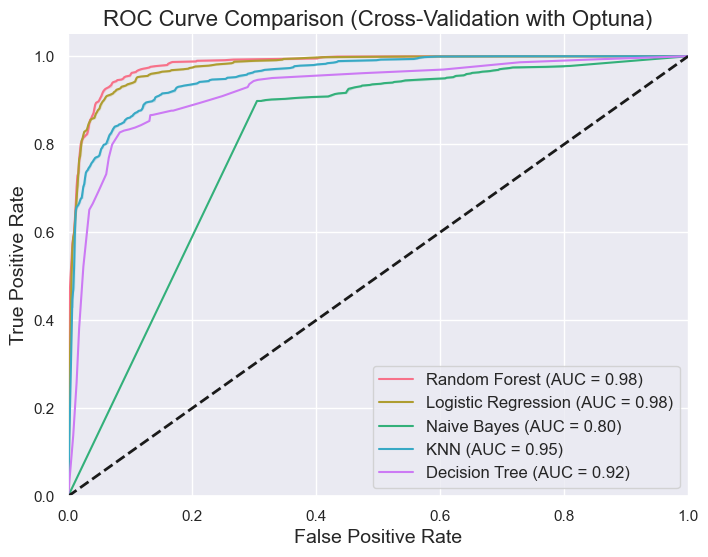

Random Forest ROC AUC (Cross-Validation): 0.98
Logistic Regression ROC AUC (Cross-Validation): 0.98
Naive Bayes ROC AUC (Cross-Validation): 0.80
KNN ROC AUC (Cross-Validation): 0.95
Decision Tree ROC AUC (Cross-Validation): 0.92


In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
colors = sns.color_palette("husl", len(cv_models))

for (model_name, pred_proba), color in zip(cv_models.items(), colors):
    fpr, tpr, _ = roc_curve(y_binary, pred_proba)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison (Cross-Validation with Optuna)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

# Print ROC AUC values
for model_name, pred_proba in cv_models.items():
    roc_auc = roc_auc_score(y_binary, pred_proba)
    print(f'{model_name} ROC AUC (Cross-Validation): {roc_auc:.2f}')

## Modeling Naive Model (Using 2-3 Level Trees)

In [27]:
def objective_compact_dt(trial):
    # Limit the max_depth to 2 or 3 to create a compact tree
    max_depth = trial.suggest_int("max_depth", 2, 3)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    dt_model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    
    score = cross_val_score(dt_model, X, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    
    # Save the model if it's the best so far
    trial.set_user_attr(key="best_model", value=dt_model)
    
    return score

[I 2024-08-21 18:16:33,866] A new study created in memory with name: no-name-f1a2d8df-f631-4f97-b8a2-8e42eb181006


Optimizing Compact Decision Tree...


Best trial: 0. Best value: 0.920101:   2%|▏         | 1/50 [00:00<00:06,  7.42it/s]

[I 2024-08-21 18:16:33,999] Trial 0 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:   4%|▍         | 2/50 [00:00<00:06,  7.42it/s]

[I 2024-08-21 18:16:34,134] Trial 1 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:   6%|▌         | 3/50 [00:00<00:06,  7.36it/s]

[I 2024-08-21 18:16:34,272] Trial 2 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:   8%|▊         | 4/50 [00:00<00:06,  7.46it/s]

[I 2024-08-21 18:16:34,404] Trial 3 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  10%|█         | 5/50 [00:00<00:05,  7.60it/s]

[I 2024-08-21 18:16:34,531] Trial 4 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  12%|█▏        | 6/50 [00:00<00:05,  7.63it/s]

[I 2024-08-21 18:16:34,659] Trial 5 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  14%|█▍        | 7/50 [00:00<00:05,  7.63it/s]

[I 2024-08-21 18:16:34,791] Trial 6 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  16%|█▌        | 8/50 [00:01<00:05,  7.63it/s]

[I 2024-08-21 18:16:34,923] Trial 7 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  18%|█▊        | 9/50 [00:01<00:05,  7.59it/s]

[I 2024-08-21 18:16:35,056] Trial 8 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  20%|██        | 10/50 [00:01<00:05,  7.66it/s]

[I 2024-08-21 18:16:35,184] Trial 9 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  22%|██▏       | 11/50 [00:01<00:05,  7.48it/s]

[I 2024-08-21 18:16:35,326] Trial 10 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  24%|██▍       | 12/50 [00:01<00:05,  7.32it/s]

[I 2024-08-21 18:16:35,468] Trial 11 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  26%|██▌       | 13/50 [00:01<00:04,  7.41it/s]

[I 2024-08-21 18:16:35,598] Trial 12 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  28%|██▊       | 14/50 [00:01<00:04,  7.30it/s]

[I 2024-08-21 18:16:35,740] Trial 13 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  30%|███       | 15/50 [00:02<00:04,  7.27it/s]

[I 2024-08-21 18:16:35,880] Trial 14 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  32%|███▏      | 16/50 [00:02<00:04,  7.37it/s]

[I 2024-08-21 18:16:36,011] Trial 15 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  34%|███▍      | 17/50 [00:02<00:04,  7.30it/s]

[I 2024-08-21 18:16:36,151] Trial 16 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  36%|███▌      | 18/50 [00:02<00:04,  7.26it/s]

[I 2024-08-21 18:16:36,290] Trial 17 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  38%|███▊      | 19/50 [00:02<00:04,  7.19it/s]

[I 2024-08-21 18:16:36,433] Trial 18 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  40%|████      | 20/50 [00:02<00:04,  7.10it/s]

[I 2024-08-21 18:16:36,578] Trial 19 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  42%|████▏     | 21/50 [00:02<00:04,  7.14it/s]

[I 2024-08-21 18:16:36,717] Trial 20 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  44%|████▍     | 22/50 [00:02<00:03,  7.08it/s]

[I 2024-08-21 18:16:36,860] Trial 21 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  46%|████▌     | 23/50 [00:03<00:03,  7.08it/s]

[I 2024-08-21 18:16:37,001] Trial 22 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  48%|████▊     | 24/50 [00:03<00:03,  7.05it/s]

[I 2024-08-21 18:16:37,143] Trial 23 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  50%|█████     | 25/50 [00:03<00:03,  7.09it/s]

[I 2024-08-21 18:16:37,282] Trial 24 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  52%|█████▏    | 26/50 [00:03<00:03,  6.98it/s]

[I 2024-08-21 18:16:37,428] Trial 25 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  54%|█████▍    | 27/50 [00:03<00:03,  6.90it/s]

[I 2024-08-21 18:16:37,579] Trial 26 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  56%|█████▌    | 28/50 [00:03<00:03,  7.02it/s]

[I 2024-08-21 18:16:37,717] Trial 27 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  58%|█████▊    | 29/50 [00:03<00:02,  7.08it/s]

[I 2024-08-21 18:16:37,856] Trial 28 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  60%|██████    | 30/50 [00:04<00:02,  7.14it/s]

[I 2024-08-21 18:16:37,992] Trial 29 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  62%|██████▏   | 31/50 [00:04<00:02,  7.11it/s]

[I 2024-08-21 18:16:38,135] Trial 30 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  64%|██████▍   | 32/50 [00:04<00:02,  7.22it/s]

[I 2024-08-21 18:16:38,268] Trial 31 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  66%|██████▌   | 33/50 [00:04<00:02,  7.13it/s]

[I 2024-08-21 18:16:38,409] Trial 32 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  68%|██████▊   | 34/50 [00:04<00:02,  7.24it/s]

[I 2024-08-21 18:16:38,545] Trial 33 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  70%|███████   | 35/50 [00:04<00:02,  7.33it/s]

[I 2024-08-21 18:16:38,678] Trial 34 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  72%|███████▏  | 36/50 [00:04<00:01,  7.33it/s]

[I 2024-08-21 18:16:38,814] Trial 35 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  74%|███████▍  | 37/50 [00:05<00:01,  7.35it/s]

[I 2024-08-21 18:16:38,948] Trial 36 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  76%|███████▌  | 38/50 [00:05<00:01,  7.39it/s]

[I 2024-08-21 18:16:39,082] Trial 37 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  78%|███████▊  | 39/50 [00:05<00:01,  7.44it/s]

[I 2024-08-21 18:16:39,215] Trial 38 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  80%|████████  | 40/50 [00:05<00:01,  7.44it/s]

[I 2024-08-21 18:16:39,349] Trial 39 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  82%|████████▏ | 41/50 [00:05<00:01,  7.29it/s]

[I 2024-08-21 18:16:39,493] Trial 40 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  84%|████████▍ | 42/50 [00:05<00:01,  7.20it/s]

[I 2024-08-21 18:16:39,636] Trial 41 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  86%|████████▌ | 43/50 [00:05<00:00,  7.13it/s]

[I 2024-08-21 18:16:39,779] Trial 42 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  88%|████████▊ | 44/50 [00:06<00:00,  7.24it/s]

[I 2024-08-21 18:16:39,913] Trial 43 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  90%|█████████ | 45/50 [00:06<00:00,  7.08it/s]

[I 2024-08-21 18:16:40,062] Trial 44 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  92%|█████████▏| 46/50 [00:06<00:00,  7.03it/s]

[I 2024-08-21 18:16:40,206] Trial 45 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  94%|█████████▍| 47/50 [00:06<00:00,  7.02it/s]

[I 2024-08-21 18:16:40,349] Trial 46 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  96%|█████████▌| 48/50 [00:06<00:00,  7.02it/s]

[I 2024-08-21 18:16:40,492] Trial 47 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101:  98%|█████████▊| 49/50 [00:06<00:00,  7.10it/s]

[I 2024-08-21 18:16:40,628] Trial 48 finished with value: 0.9201009988895358 and parameters: {'max_depth': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.9201009988895358.


Best trial: 0. Best value: 0.920101: 100%|██████████| 50/50 [00:06<00:00,  7.24it/s]


[I 2024-08-21 18:16:40,767] Trial 49 finished with value: 0.8916007671081452 and parameters: {'max_depth': 2, 'min_samples_split': 3}. Best is trial 0 with value: 0.9201009988895358.

Best hyperparameters for Compact Decision Tree: {'max_depth': 3, 'min_samples_split': 5}
Best model for Compact Decision Tree: DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
Evaluating Compact Decision Tree...


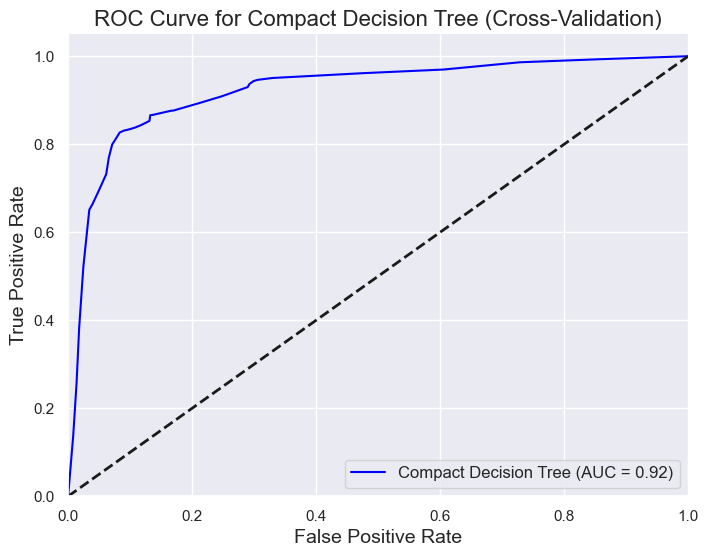

Compact Decision Tree ROC AUC (Cross-Validation): 0.92


In [28]:
# Reuse the callback function from before
# Optimize the compact Decision Tree
print("Optimizing Compact Decision Tree...")
study_compact_dt = optuna.create_study(direction="maximize")
study_compact_dt.optimize(objective_compact_dt, n_trials=50, callbacks=[callback], show_progress_bar=True)

# Retrieve the best model
best_compact_dt_model = study_compact_dt.user_attrs["best_model"]

# Print out the best hyperparameters and the model
print(f"\nBest hyperparameters for Compact Decision Tree: {study_compact_dt.best_params}")
print(f"Best model for Compact Decision Tree: {best_compact_dt_model}")

# Evaluate the compact Decision Tree model
print(f"Evaluating Compact Decision Tree...")
cv_pred_proba_compact_dt = cross_val_predict(best_compact_dt_model, X, y_binary, cv=cv, method='predict_proba')[:, 1]

# Plot ROC curve for the compact Decision Tree with Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_binary, cv_pred_proba_compact_dt)
roc_auc = auc(fpr, tpr)
sns.lineplot(x=fpr, y=tpr, label=f'Compact Decision Tree (AUC = {roc_auc:.2f})', color="blue")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Compact Decision Tree (Cross-Validation)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

# Print ROC AUC value for the compact Decision Tree
roc_auc_compact_dt = roc_auc_score(y_binary, cv_pred_proba_compact_dt)
print(f'Compact Decision Tree ROC AUC (Cross-Validation): {roc_auc_compact_dt:.2f}')

Other Metrics.

In [41]:
# Initialize a dictionary to store the results
metrics_results = {
    'Model': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'ROC AUC': []
}

# Function to evaluate and store metrics
def evaluate_model(model_name, y_true, y_pred_proba, threshold=0.5):
    # Convert probabilities to binary predictions using the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Append results to the dictionary
    metrics_results['Model'].append(model_name)
    metrics_results['Accuracy'].append(accuracy)
    metrics_results['Recall'].append(recall)
    metrics_results['Precision'].append(precision)
    metrics_results['ROC AUC'].append(roc_auc)

# Evaluate each model and store the metrics
for model_name, pred_proba in cv_models.items():
    evaluate_model(model_name, y_binary, pred_proba)

# Convert the results dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Print the DataFrame with the results
display(metrics_df.sort_values('ROC AUC', ascending=False))

,Model,Accuracy,Recall,Precision,ROC AUC
0,Random Forest,0.928082,0.907967,0.945637,0.980811
1,Logistic Regression,0.923973,0.910714,0.935120,0.975950
3,KNN,0.882192,0.842033,0.914925,0.954570
4,Decision Tree,0.870548,0.831044,0.901639,0.922558
2,Naive Bayes,0.747260,0.907967,0.686397,0.800903


## Comments

Even though we tweaked the hyperparameters like max_depth and min_samples_split, the Decision Tree still struggled to match the performance of models like Random Forest or Gradient Boosting (it still performed quite nicely, because the Housing dataset was turned from a regression problem to a binary outcome - providing an easy dataset to "learn"). These ensemble models combine multiple decision trees, which helps them generalize better and be more robust to variations in the data. This is why ensemble methods often outperform a single Decision Tree—they average out the weaknesses of individual trees and produce a stronger overall model. So, while a Decision Tree is useful for understanding the basic structure of the data, it often can't compete with the predictive power of these more advanced models.